# AlexNet with 1X1 Convolutions

### 1. Import neccesary libraries

In [ ]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import os

PyTorch Version:  1.0.1
Torchvision Version:  0.2.1


In [ ]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structureme
data_dir = "/home/trainee/Intern/DRDO/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
os.listdir(data_dir)

['train', 'val']

In [ ]:
val_acc_history = []
loss_values=[]
accuracy_values=[]
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            loss_values.append(epoch_loss)
            accuracy_values.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print() 

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# def sb_forward(self, x):
#     x = self.features(x)
#     #x = self.avgpool(x)
#     x = x.view(x.size(0), 2 * 1 * 1)
#     x = self.classifier(x)
#     return x


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# model_ft = models.alexnet(pretrained=True)
# set_parameter_requires_grad(model_ft, feature_extract)
# # num_ftrs = model_ft.classifier[1].in_features
# num_ftrs = 256
# features = model_ft.features.children()
# print(features)
# model_ft.features= nn.Sequential(*list(features)[:],nn.Conv2d(256,num_ftrs,kernel_size=(1,1),stride=(2,2)),
#                                  nn.ReLU(inplace=True),
#                                  nn.Conv2d(256,256,kernel_size=(1,1),stride=(1,1)),
#                                  nn.ReLU(inplace=True),
#                                  nn.Conv2d(256,2,kernel_size=(1,1),stride=(1,1)),
#                                  nn.ReLU(inplace=True),                                 
#                                  nn.AdaptiveAvgPool2d(output_size=(1,1)),
#                                  nn.ReLU(inplace=True)
#                                 )

# classifier = model_ft.classifier.children()
# model_ft.classifier= nn.Sequential(nn.Linear(2, 2))
# # model_ft.classifier[1] = nn.Conv1d(256,num_ftrs,kernel_size=(1,1),stride=(2,2))
# # num_ftrs = model_ft.classifier[4].in_features
# # model_ft.classifier[4] = nn.Conv1d(256,256,kernel_size=(1,1),stride=(1,1))
# # num_ftrs = model_ft.classifier[6].in_features
# # model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
# input_size = 224
        
# print(model_ft)

In [ ]:
model_ft = models.alexnet(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
# num_ftrs = model_ft.classifier[1].in_features
num_ftrs = 256
features = model_ft.features.children()
print(features)
model_ft.features= nn.Sequential(*list(features)[:],nn.Conv2d(256,9216,kernel_size=(1,1),stride=(1,1)),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(9216,4096,kernel_size=(1,1),stride=(1,1)),
                                 nn.ReLU(inplace=True),
                                 nn.Conv2d(4096,4096,kernel_size=(1,1),stride=(1,1)),
                                 nn.ReLU(inplace=True), 
                                 nn.Conv2d(4096,2,kernel_size=(1,1),stride=(1,1)),
                                 nn.ReLU(inplace=True),                                 
                                 nn.AdaptiveAvgPool2d(output_size=(1,1)),
                                 nn.ReLU(inplace=True)
                                )

classifier = model_ft.classifier.children()
model_ft.classifier= nn.Sequential(nn.Linear(2, 2))
# model_ft.classifier[1] = nn.Conv1d(256,num_ftrs,kernel_size=(1,1),stride=(2,2))
# num_ftrs = model_ft.classifier[4].in_features
# model_ft.classifier[4] = nn.Conv1d(256,256,kernel_size=(1,1),stride=(1,1))
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=2, bias=True)
input_size = 224
        
print(model_ft)

<generator object Module.children at 0x7f06a0b00ca8>
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 9216, kernel_size=(1, 1), stride=(1, 1))
    (14): ReLU(inplace)
    (15): Conv2d(9216, 4096, kernel_size=(1, 1), stride=(1, 1))
    (16)

In [ ]:
# import types
# model_ft.forward = types.MethodType(sb_forward, model_ft)

# import types
# model_ft.forward = types.MethodType(sb_forward, model_ft)


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.13.weight
	 features.13.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.19.weight
	 features.19.bias
	 classifier.0.weight
	 classifier.0.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()



# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=15, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.6978 Acc: 0.4918
val Loss: 0.6825 Acc: 0.5425

Epoch 1/14
----------
train Loss: 0.6749 Acc: 0.6598
val Loss: 0.6650 Acc: 0.7778

Epoch 2/14
----------
train Loss: 0.6526 Acc: 0.7541
val Loss: 0.6556 Acc: 0.5882

Epoch 3/14
----------
train Loss: 0.6349 Acc: 0.7090
val Loss: 0.6243 Acc: 0.7516

Epoch 4/14
----------
train Loss: 0.6034 Acc: 0.7295
val Loss: 0.5982 Acc: 0.7908

Epoch 5/14
----------
train Loss: 0.5714 Acc: 0.7582
val Loss: 0.5801 Acc: 0.7124

Epoch 6/14
----------
train Loss: 0.5424 Acc: 0.8320
val Loss: 0.5524 Acc: 0.7582

Epoch 7/14
----------
train Loss: 0.5212 Acc: 0.8033
val Loss: 0.5310 Acc: 0.8627

Epoch 8/14
----------
train Loss: 0.5244 Acc: 0.7910
val Loss: 0.5177 Acc: 0.8366

Epoch 9/14
----------
train Loss: 0.4852 Acc: 0.8525
val Loss: 0.5163 Acc: 0.7778

Epoch 10/14
----------
train Loss: 0.4646 Acc: 0.8525
val Loss: 0.4972 Acc: 0.8105

Epoch 11/14
----------
train Loss: 0.4737 Acc: 0.8320
val Loss: 0.4739 Acc: 0.8497

Ep

In [ ]:
plt.plot(val_acc_history)

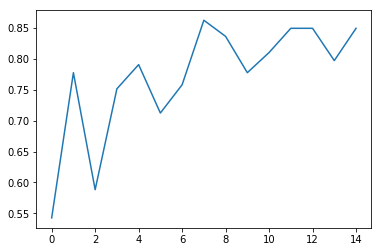

In [ ]:
plt.show()

In [ ]:
torch.save(model_ft, '/home/trainee/Intern/DRDO/alex.pth')

In [ ]:
from PIL import Image
from pathlib import Path
import numpy as np
image = Image.open(Path('/home/trainee/Intern nit uk/DRDO/1.jpg'))
# trans = transforms.ToPILImage()
# trans1 = transforms.ToTensor()

# image = torchvision.transforms.Tensor()
# image = torchvision.transforms.
#image = image.type(torch.FloatTensor)

data_trans={
    'image' : transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image=data_trans['image']
output = model_ft(image)